# Prepare model

In [1]:
import os
import re
import sys
sys.path.insert(0, '/media/allen/mass/pytorch_Realtime_Multi-Person_Pose_Estimation/')
import cv2
import math
import time
import scipy
import argparse
import matplotlib
import numpy as np
import pylab as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from collections import OrderedDict
from scipy.ndimage.filters import gaussian_filter
from scipy.spatial.distance import cdist
from network.rtpose_vgg import get_model
from network.post import decode_pose, plot_pose
from training.datasets.coco_data.preprocessing import (inception_preprocess,
                                              rtpose_preprocess,
                                              ssd_preprocess, vgg_preprocess)
from network import im_transform
from evaluate.coco_eval import get_multiplier, get_outputs, handle_paf_and_heat

model = get_model('vgg19') 
weight_name = '../external/pose_model_scratch.pth'
checkpoint = torch.load(weight_name)
model_dict = model.state_dict()
ckpt = {k.replace("module.", ""): v for k, v in checkpoint.items() if k.replace("module.", "") in model_dict and torch.isnan(v).sum() == 0}
model_dict.update(ckpt)
model.load_state_dict(model_dict)
model = model.cuda()
# model.float()
model.eval()

Bulding VGG19


rtpose_model(
  (model0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(i

# Prepare image and heatmaps, paf

In [48]:
os.mkdir("/media/allen/mass/reid/dukemtmc-reid_aligned/bounding_box_train/")
os.mkdir("/media/allen/mass/reid/dukemtmc-reid_aligned/bounding_box_test/")
os.mkdir("/media/allen/mass/reid/dukemtmc-reid_aligned/query/")
os.mkdir("/media/allen/mass/reid/dukemtmc-reid_aligned/garbage/")

In [17]:
os.makedirs("/media/allen/mass/andy_pose")

In [35]:
os.path.basename(path)

'9999_c1s1_1680_01.jpg'

In [33]:
R = np.array([0,0,255])
G = np.array([0,255,0])
B = np.array([255,0,0])
W = np.array([255,255,255])
BK = np.array([0,0,0])
Y = R + G
P = R + B
C = np.array([B,G,R,W,BK,Y,P])
color_map = {0:'red', 1:'green', 2:'blue', 3:'white', 4:'black', 5:'yellow', 6:'purple'}
color_np_map = {0:(0,0,255), 1:(0,255,0), 2:(255,0,0), 3:(255,255,255), 4:(0,0,0), 5:(0,255,255), 6:(255,0,255)}

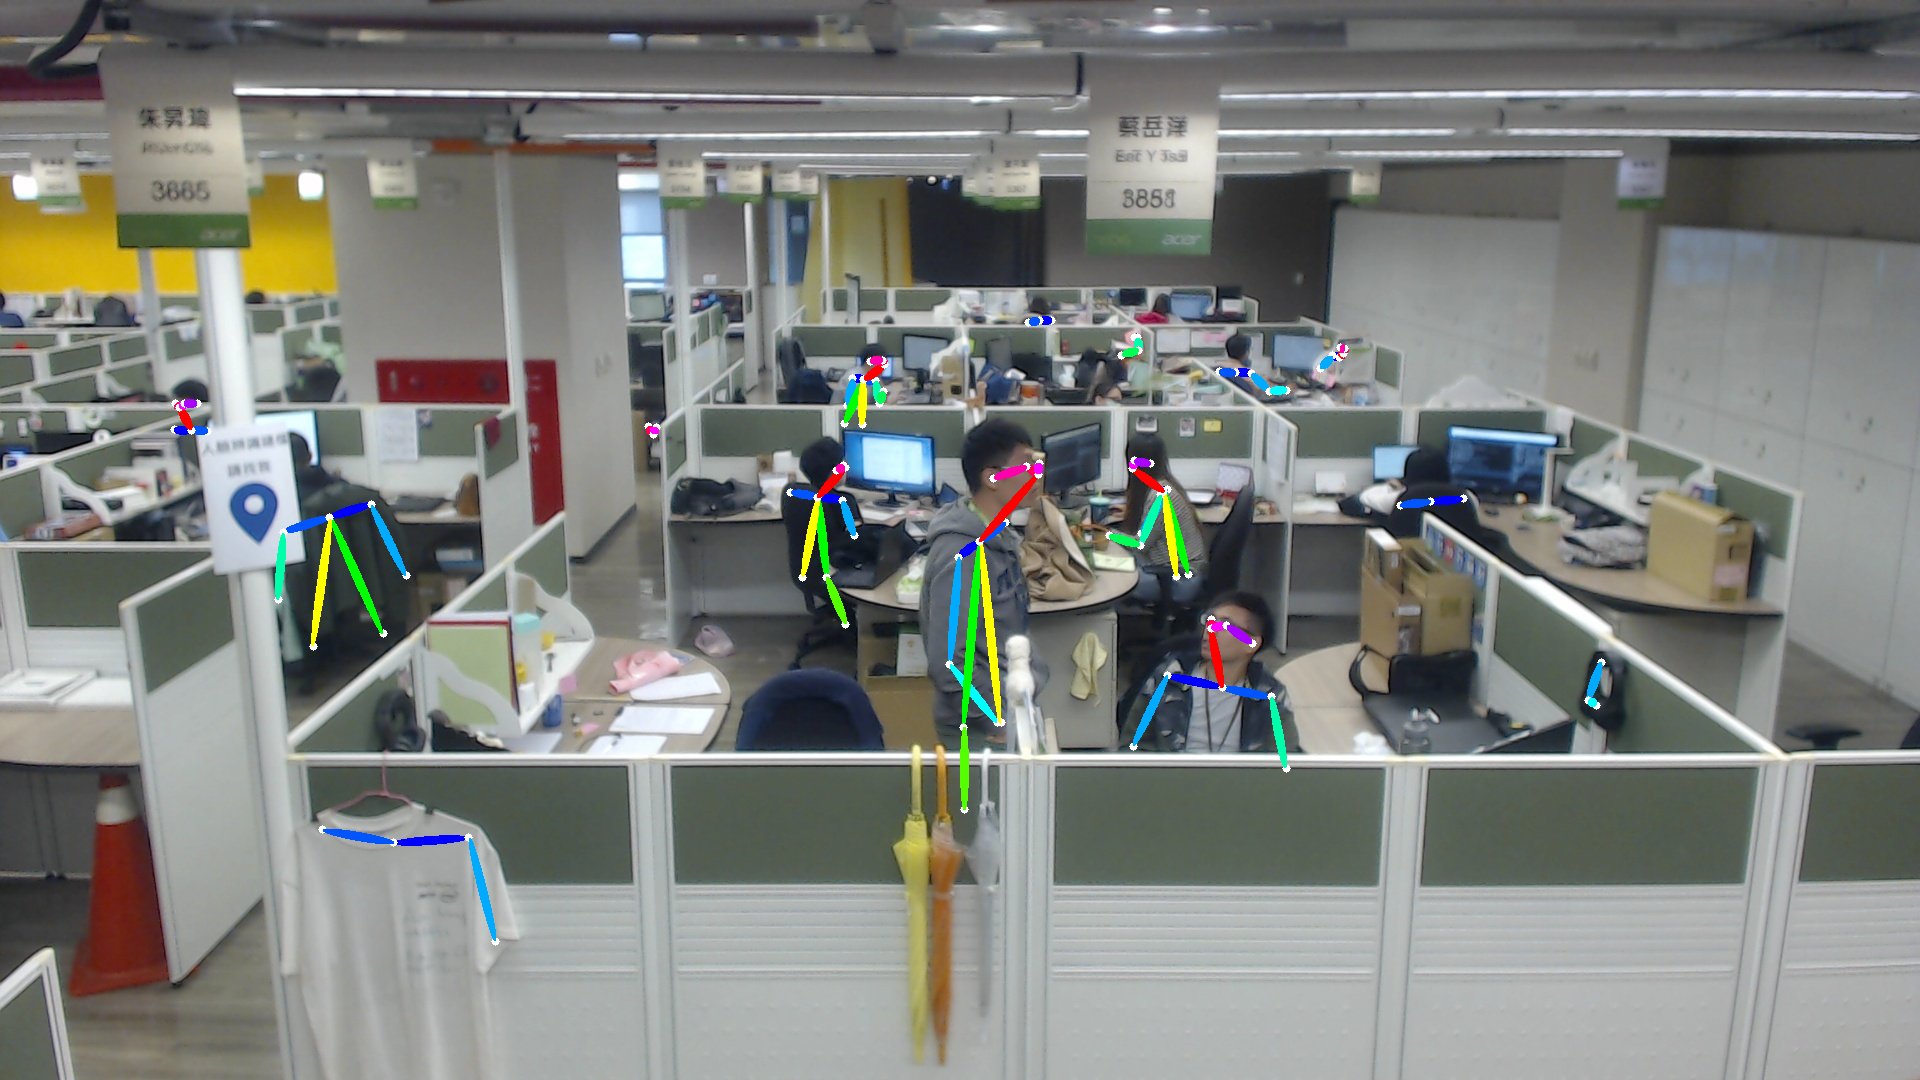

In [2]:
import glob
import shutil
from PIL import Image
from torchvision import transforms as T
trans = T.Compose([T.ToTensor(), T.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])])

# src = "/media/allen/mass/reid/dukemtmc-reid/query/"
src = "/media/allen/mass/sogo/testing/JPEGImages/"
dst = "/media/allen/mass/reid/dukemtmc-reid_aligned/query/"
garbage_dst = "/media/allen/mass/reid/dukemtmc-reid_aligned/garbage/"

# imgs_path = sorted([os.path.join(root, f) for root, _, files in os.walk(src) for f in files if '.jpg' in f or '.png' in f])
imgs_path = ["/media/allen/mass/office/office_valid/CAM1-2019-11-12_11-28-14_9900.jpg"]
DETECT = [0,15,14,17,16,1,5,2,11,8,12,9]
IMPORTANT = [5,2,8,11]
w_ratio = 0.125
h_ratio = 0.125
for path in imgs_path:
#     fname = os.path.join("/media/allen/mass/sogo_detect/", os.path.basename(path))
    img = cv2.imread(path)
# imgs = '/media/allen/mass/IMG_1185.TRIM.MOV'
# cap = cv2.VideoCapture(imgs)
# count = 0

# while cap.isOpened():
#     ret, img = cap.read()  
#     img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
#     h, w = img.shape[:2]
#     img = cv2.resize(img, (w//4, h//4))
    
    pil_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   
    pil_img = Image.fromarray(pil_img)    
        
    batch_var = trans(pil_img).unsqueeze(0).cuda()
    with torch.no_grad():
        predicted_outputs, _ = model(batch_var)


    output1, output2 = predicted_outputs[-2], predicted_outputs[-1]
    heatmap = output2.cpu().data.numpy().transpose(0, 2, 3, 1)[0]
    paf = output1.cpu().data.numpy().transpose(0, 2, 3, 1)[0]

    real_shape = img.shape

    heatmap = cv2.resize(heatmap, None, fx=8, fy=8, interpolation=cv2.INTER_CUBIC)
    heatmap = heatmap[0:real_shape[0], 0:real_shape[1], :]
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)

    paf = cv2.resize(paf, None, fx=8, fy=8, interpolation=cv2.INTER_CUBIC)
    paf = paf[0:real_shape[0], 0:real_shape[1], :]
    paf = cv2.resize(paf, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)

    param = {'thre1': 0.1, 'thre2': 0.05, 'thre3': 0.5}
    candidate, subset = decode_pose(
        img, param, heatmap, paf)  

    final = []
    for person in subset:
        final.append(person)
    
    to_plot, canvas = plot_pose(img, candidate, final)
#     fname = '/media/allen/mass/andy_pose/{:06}.jpg'.format(count)
#     break
#     to_plot_ = img.copy()
    
#     for i in range(len(final)):
#         person_coords = []
#         for joint in IMPORTANT:
#             index = final[i][joint]
#             if index < 0: continue
#             person_coords.append((candidate[int(index)][:2]).astype(int))
        
        
#             x_coord1 = np.linspace(candidate[int(final[i][2])][0], 
#                                   candidate[int(final[i][11])][0], num=10).astype(int)
#             y_coord1 = np.linspace(candidate[int(final[i][2])][1], 
#                                   candidate[int(final[i][11])][1], num=10).astype(int)
#             x_coord2 = np.linspace(candidate[int(final[i][5])][0], 
#                                   candidate[int(final[i][8])][0], num=10).astype(int)
#             y_coord2 = np.linspace(candidate[int(final[i][5])][1], 
#                                   candidate[int(final[i][8])][1], num=10).astype(int)
            
#             sample_color = []
#             for x, y in zip(x_coord1, y_coord1):
#                 sample_color.append(to_plot[y, x, :])
# #                 cv2.circle(to_plot_, (x,y), 4, (255,255,255), thickness=-1)
#             for x, y in zip(x_coord2, y_coord2):
#                 sample_color.append(to_plot[y, x, :])
# #                 cv2.circle(to_plot_, (x,y), 4, (255,255,255), thickness=-1)
#             color = np.array([np.median(np.array(sample_color), axis=0)])
#             idx = cdist(color, C).argsort()[0][0]
# #             pred_color = color_map[idx]
# #             print(pred_color)
# #         if pred_color == 'white':
# #             shutil.copy(path, fname)
#         for joint in range(18):
#             index = final[i][joint]
#             if index < 0: continue
#             person_coords.append((candidate[int(index)][:2]).astype(int))
            
#         person_coords = np.array(person_coords)
#         x1 = np.min(person_coords[:,0])
#         y1 = np.min(person_coords[:,1])
#         x2 = np.max(person_coords[:,0])
#         y2 = np.max(person_coords[:,1])
        
#         offset_w = int((x2 - x1)*w_ratio)
#         offset_h = int((y2 - y1)*h_ratio)
#         x1 = max([0,x1-offset_w])
#         y1 = max([0,y1-offset_h])
#         x2 = min([real_shape[1],x2+offset_w])
#         cv2.rectangle(to_plot_, (x1, y1), (x2, y2), color_np_map[idx], 2)
        
#     cv2.imwrite(fname, canvas)
#     count += 1
#     break
# #         cv2.rectangle(to_plot_, (x1, y1), (x2, y2), (0,0,0), 2)
# # #         h, w, _ = temp.shape
# # #         if w < 10 or h < 10:
# # #             shutil.copy(path, os.path.join(garbage_dst, path.split("/")[-1]))
# # #         else:
# #         cv2.imwrite(os.path.join(dst, path.split("/")[-1]), temp)
# #     else:
# #         shutil.copy(path, os.path.join(garbage_dst, path.split("/")[-1]))
    
temp = cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB)    
pil_img = Image.fromarray(temp)
pil_img

In [23]:
img.shape

(1080, 1920, 3)

In [14]:
canvas.shape

(1280, 720, 3)

In [8]:
import glob
import shutil
from PIL import Image
from torchvision import transforms as T
trans = T.Compose([T.ToTensor(), T.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])])

# src = "/media/allen/mass/reid/dukemtmc-reid/query/"
src = "/media/allen/mass/sogo/testing/JPEGImages/"
dst = "/media/allen/mass/reid/dukemtmc-reid_aligned/query/"
garbage_dst = "/media/allen/mass/reid/dukemtmc-reid_aligned/garbage/"

# imgs_path = sorted([os.path.join(root, f) for root, _, files in os.walk(src) for f in files if '.jpg' in f or '.png' in f])
imgs_path = ["/media/allen/mass/sogo/testing/JPEGImages/A1_2018-07-21_16_50_19_03_A1_2018-07-21_17_20_12_03.mp4_5580_withG.jpg"]
DETECT = [0,15,14,17,16,1,5,2,11,8,12,9]
IMPORTANT = [5,2,8,11]
w_ratio = 0.125
h_ratio = 0.125
for path in imgs_path:
    fname = os.path.join("/media/allen/mass/sogo_detect/", os.path.basename(path))
    img = cv2.imread(path)
    multiplier = get_multiplier(img) 
    heatmap_avg = np.zeros((img.shape[0], img.shape[1], 19))
    paf_avg = np.zeros((img.shape[0], img.shape[1], 38))
    max_scale = multiplier[-1]
    max_size = max_scale * img.shape[0] 
    # padding
    max_cropped, _, _ = im_transform.crop_with_factor(
        img, max_size, factor=8, is_ceil=True)
    batch_images = np.zeros(
        (len(multiplier), 3, max_cropped.shape[0], max_cropped.shape[1]))
    for m in range(len(multiplier)): 
        scale = multiplier[m]
        inp_size = scale * img.shape[0]

        # padding
        im_croped, im_scale, real_shape = im_transform.crop_with_factor(
            img, inp_size, factor=8, is_ceil=True)
            
        pil_im_croped = cv2.cvtColor(im_croped, cv2.COLOR_BGR2RGB) 
        pil_im_croped = Image.fromarray(pil_im_croped)
        trans(pil_img).unsqueeze(0).cuda()
      
    pil_img = Image.fromarray(pil_img)    
        
    batch_var = 
    with torch.no_grad():
        predicted_outputs, _ = model(batch_var)


    output1, output2 = predicted_outputs[-2], predicted_outputs[-1]
    heatmap = output2.cpu().data.numpy().transpose(0, 2, 3, 1)[0]
    paf = output1.cpu().data.numpy().transpose(0, 2, 3, 1)[0]

    real_shape = img.shape

    heatmap = cv2.resize(heatmap, None, fx=8, fy=8, interpolation=cv2.INTER_CUBIC)
    heatmap = heatmap[0:real_shape[0], 0:real_shape[1], :]
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)

    paf = cv2.resize(paf, None, fx=8, fy=8, interpolation=cv2.INTER_CUBIC)
    paf = paf[0:real_shape[0], 0:real_shape[1], :]
    paf = cv2.resize(paf, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)

    param = {'thre1': 0.1, 'thre2': 0.05, 'thre3': 0.5}
    candidate, subset = decode_pose(
        img, param, heatmap, paf)  

    final = []
    for person in subset:
#         if (person[IMPORTANT] > 0).sum() == len(IMPORTANT):
        final.append(person)
    
    to_plot, canvas = plot_pose(img, candidate, final)
#     break
    to_plot_ = img.copy()
    
    for i in range(len(final)):
        person_coords = []
        for joint in IMPORTANT:
            index = final[i][joint]
            if index < 0: continue
            person_coords.append((candidate[int(index)][:2]).astype(int))
        
        
            x_coord1 = np.linspace(candidate[int(final[i][2])][0], 
                                  candidate[int(final[i][11])][0], num=10).astype(int)
            y_coord1 = np.linspace(candidate[int(final[i][2])][1], 
                                  candidate[int(final[i][11])][1], num=10).astype(int)
            x_coord2 = np.linspace(candidate[int(final[i][5])][0], 
                                  candidate[int(final[i][8])][0], num=10).astype(int)
            y_coord2 = np.linspace(candidate[int(final[i][5])][1], 
                                  candidate[int(final[i][8])][1], num=10).astype(int)
            
            sample_color = []
            for x, y in zip(x_coord1, y_coord1):
                sample_color.append(to_plot[y, x, :])
#                 cv2.circle(to_plot_, (x,y), 4, (255,255,255), thickness=-1)
            for x, y in zip(x_coord2, y_coord2):
                sample_color.append(to_plot[y, x, :])
#                 cv2.circle(to_plot_, (x,y), 4, (255,255,255), thickness=-1)
            color = np.array([np.median(np.array(sample_color), axis=0)])
            idx = cdist(color, C).argsort()[0][0]
#             pred_color = color_map[idx]
#             print(pred_color)
#         if pred_color == 'white':
#             shutil.copy(path, fname)
        for joint in range(18):
            index = final[i][joint]
            if index < 0: continue
            person_coords.append((candidate[int(index)][:2]).astype(int))
            
        person_coords = np.array(person_coords)
        x1 = np.min(person_coords[:,0])
        y1 = np.min(person_coords[:,1])
        x2 = np.max(person_coords[:,0])
        y2 = np.max(person_coords[:,1])
        
        offset_w = int((x2 - x1)*w_ratio)
        offset_h = int((y2 - y1)*h_ratio)
        x1 = max([0,x1-offset_w])
        y1 = max([0,y1-offset_h])
        x2 = min([real_shape[1],x2+offset_w])
        cv2.rectangle(to_plot_, (x1, y1), (x2, y2), color_np_map[idx], 2)
        
#         cv2.imwrite(fname, to_plot_)
#         cv2.rectangle(to_plot_, (x1, y1), (x2, y2), (0,0,0), 2)
# #         h, w, _ = temp.shape
# #         if w < 10 or h < 10:
# #             shutil.copy(path, os.path.join(garbage_dst, path.split("/")[-1]))
# #         else:
#         cv2.imwrite(os.path.join(dst, path.split("/")[-1]), temp)
#     else:
#         shutil.copy(path, os.path.join(garbage_dst, path.split("/")[-1]))
    
temp = cv2.cvtColor(to_plot_, cv2.COLOR_BGR2RGB)    
pil_img = Image.fromarray(temp)
pil_img

SyntaxError: invalid syntax (<ipython-input-8-7e768ad6ff60>, line 45)

In [27]:
tuple(color_np_map[idx])

(0, 0, 0)

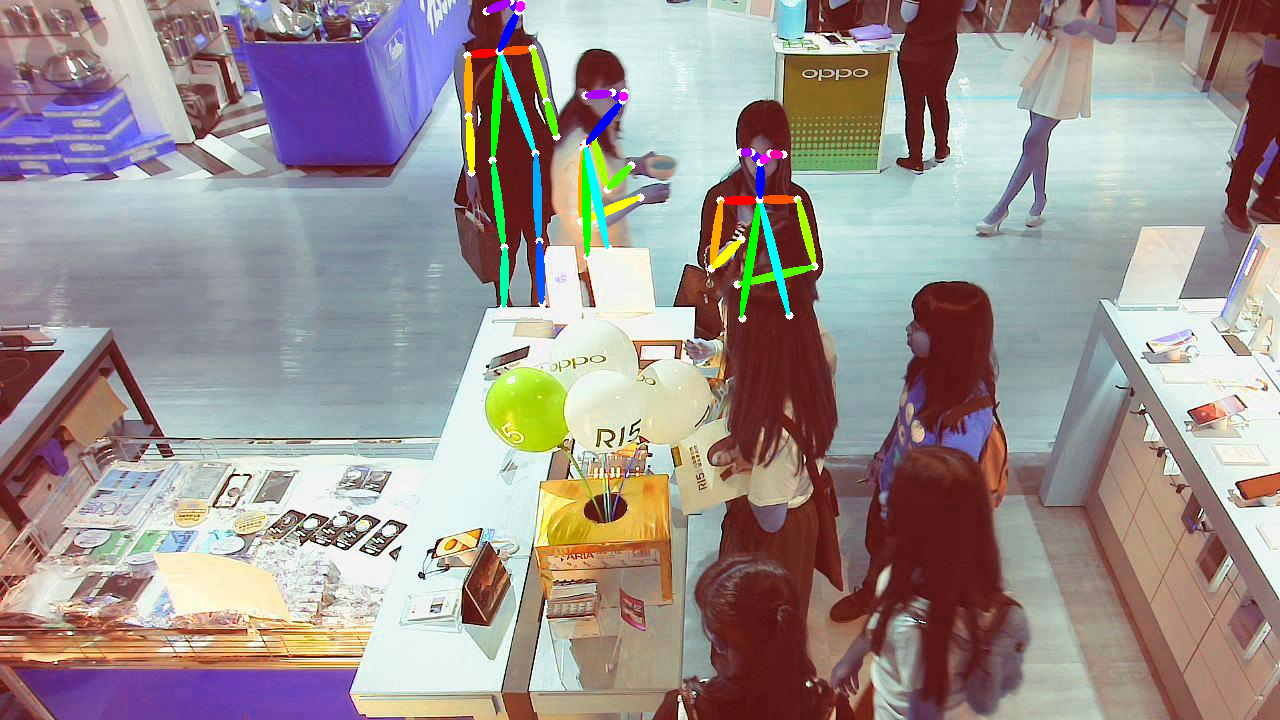

In [45]:
# to_plot, canvas = plot_pose(img, candidate, subset)
pil_img = Image.fromarray(canvas)
pil_img

In [6]:
for person in subset:
    print((person[IMPORTANT] > 0).sum())

4
4
4
1
1
1
1


In [84]:
pred_color

'black'

In [72]:
color = np.array([np.median(np.array(sample_color), axis=0)])

In [82]:
idx = cdist(color, C).argsort()[0][0]
color_map[idx]

'black'

In [46]:
candidate[1]

array([71.        , 10.        ,  0.69252408,  1.        ,  1.        ])

In [32]:
final

[]

In [8]:
import glob
import shutil
from PIL import Image
from torchvision import transforms as T
trans = T.Compose([T.ToTensor(), T.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])])

# imgs_path = sorted([os.path.join(root, f) for root, _, files in os.walk(src) for f in files if '.jpg' in f or '.png' in f])
imgs_path = ["/media/allen/mass/reid/market1501/bounding_box_train/0002_c1s1_000451_03.jpg"]

IMPORTANT = [5,2,11,8]
w_ratio = 0.125
h_ratio = 0.125
for path in imgs_path:

    img = cv2.imread(path)
    pil_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   
    pil_img = Image.fromarray(pil_img)    
        
    batch_var = trans(pil_img).unsqueeze(0).cuda()

    predicted_outputs, _ = model(batch_var)


    output1, output2 = predicted_outputs[-2], predicted_outputs[-1]
    

In [9]:
print(output1.shape)
print(output2.shape)
print(real_shape)

torch.Size([1, 38, 33, 13])
torch.Size([1, 19, 33, 13])


In [11]:
heatmap = output2.cpu().data.numpy().transpose(0, 2, 3, 1)[0]
print(heatmap.shape)


real_shape = img.shape
print(real_shape)
heatmap = cv2.resize(heatmap, None, fx=8, fy=8, interpolation=cv2.INTER_CUBIC)
print(heatmap.shape)
heatmap = heatmap[0:real_shape[0], 0:real_shape[1], :]
print(heatmap.shape)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)
print(heatmap.shape)

(33, 13, 19)
(270, 107, 3)
(264, 104, 19)
(264, 104, 19)
(270, 107, 19)


In [23]:
for i in range(19):
    print(heatmap[:,:,i].max())

0.8623597
0.86034346
0.8929021
0.84797
0.7702619
0.8068928
0.43471578
0.1904037
0.8785214
0.8817452
0.19756007
0.7950322
0.79027
0.4463914
0.7636716
0.42263454
0.7662796
0.013301814
1.0031755


In [12]:
paf = output1.cpu().data.numpy().transpose(0, 2, 3, 1)[0]
print(paf.shape)
paf = cv2.resize(paf, None, fx=8, fy=8, interpolation=cv2.INTER_CUBIC)
print(paf.shape)
paf = paf[0:real_shape[0], 0:real_shape[1], :]
print(paf.shape)
paf = cv2.resize(paf, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)
print(paf.shape)

(33, 13, 38)
(264, 104, 38)
(264, 104, 38)
(270, 107, 38)


In [ ]:



param = {'thre1': 0.1, 'thre2': 0.05, 'thre3': 0.5}
candidate, subset = decode_pose(
    img, param, heatmap, paf)  

final = []
for person in subset:
    if np.sum(person[IMPORTANT] > 0) == len(IMPORTANT):
        final.append(person)

#     to_plot, canvas = plot_pose(img, candidate, np.array(final))

person_coords = []
if len(final) == 1:
    for joint in DETECT:
        index = final[0][joint]
        if index < 0: continue
        person_coords.append((candidate[int(index)][:2]).astype(int))
    person_coords = np.array(person_coords)
    x1 = np.min(person_coords[:,0])
    y1 = np.min(person_coords[:,1])
    x2 = np.max(person_coords[:,0])
    y2 = np.max(person_coords[:,1])
    offset_w = int((x2 - x1)*w_ratio)
    offset_h = int((y2 - y1)*h_ratio)
    x1 = max([0,x1-offset_w])
    y1 = max([0,y1-offset_h])
    x2 = min([real_shape[1],x2+offset_w])
    temp = img[y1:y2, x1:x2, :]
#         h, w, _ = temp.shape
#         if w < 10 or h < 10:
#             shutil.copy(path, os.path.join(garbage_dst, path.split("/")[-1]))
#         else:
    cv2.imwrite(os.path.join(dst, path.split("/")[-1]), temp)
else:
    shutil.copy(path, os.path.join(garbage_dst, path.split("/")[-1]))
    
# temp = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)    
# pil_img = Image.fromarray(temp)
# pil_img

In [269]:
def gaussian(kernel):
    sigma = kernel*0.4
    s = 2*(sigma**2)
    dx = np.exp(-np.square(np.arange(kernel) - int(kernel / 2)) / s)
    return np.reshape(dx,(-1,1))

Populating the interactive namespace from numpy and matplotlib


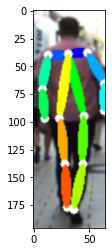

In [6]:
import glob
import shutil
from PIL import Image
from torchvision import transforms as T
trans = T.Compose([T.ToTensor(), T.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])])
src = "/media/allen/mass/reid/dukemtmc-reid/DukeMTMC-reID/bounding_box_train/"
dst_gt = "/media/allen/mass/reid/dukemtmc-reid/DukeMTMC-reID/att_map_gt"
dst_img = "/media/allen/mass/reid/dukemtmc-reid/DukeMTMC-reID/att_map_img"
if not os.path.exists(dst_gt):
    os.mkdir(dst_gt)
if not os.path.exists(dst_img):
    os.mkdir(dst_img)
# garbage_dst = "/media/allen/mass/reid/dukemtmc-reid_aligned/garbage/"

# imgs_path = sorted([os.path.join(root, f) for root, _, files in os.walk(src) for f in files if '.jpg' in f or '.png' in f])

# imgs_path = ["/media/allen/mass/reid/market1501/bounding_box_train/0160_c6s1_028326_01.jpg"]
imgs_path = ["/home/allen/pose.png"]
DETECT = [0,15,14,17,16,1,5,2,11,8,12,9]
IMPORTANT = [5,2,11,8]
w_ratio = 0.25
h_ratio = 0.25
scale = 1.4
at_maps = []
effective_img = []
for path in imgs_path:

    img = cv2.imread(path)
    try:
        pil_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   
        pil_img = Image.fromarray(pil_img)
    except:
        print(path)
        shutil.copy(path, os.path.join(garbage_dst, path.split("/")[-1]))
    batch_var = trans(pil_img).unsqueeze(0).cuda()

    predicted_outputs, _ = model(batch_var)


    output1, output2 = predicted_outputs[-2], predicted_outputs[-1]
    heatmap = output2.cpu().data.numpy().transpose(0, 2, 3, 1)[0]
    paf = output1.cpu().data.numpy().transpose(0, 2, 3, 1)[0]

    real_shape = img.shape
#     print(heatmap.shape)
    heatmap = cv2.resize(heatmap, None, fx=8, fy=8, interpolation=cv2.INTER_CUBIC)
    heatmap = heatmap[0:real_shape[0], 0:real_shape[1], :]
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)

    paf = cv2.resize(paf, None, fx=8, fy=8, interpolation=cv2.INTER_CUBIC)
    paf = paf[0:real_shape[0], 0:real_shape[1], :]
    paf = cv2.resize(paf, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)

    param = {'thre1': 0.1, 'thre2': 0.05, 'thre3': 0.5}
    candidate, subset = decode_pose(
        img, param, heatmap, paf)  

    final = []
#     if len(subset) != 1: continue
    for person in subset:
        if np.sum(person > 0) > 6:# == len(IMPORTANT):
            final.append(person)
            break
    canvas = img.copy()
    to_plot, canvas = plot_pose(img, candidate, np.array(final))

    person_coords = []
    if len(final) > 0:
        for joint in range(18):
            index = final[0][joint]
            if index < 0: continue
            coord = (candidate[int(index)][:2]).astype(int)
            prob = candidate[int(index)][2]
            if prob > 0.0:
#                 cv2.circle(canvas, tuple(coord), 4, (0,0,0), thickness=-1) 
#                 cv2.circle(canvas, tuple(coord), 2, (255,255,255), thickness=-1)
                person_coords.append(coord)
#         center = np.mean(person_coords, axis=0, dtype=int)
#         cv2.circle(canvas, tuple(center), 6, (0,0,0), thickness=-1) 
#         cv2.circle(canvas, tuple(center), 3, (255,255,255), thickness=-1)
        
        person_coords = np.array(person_coords)    
        
#         at_map = np.zeros_like(img)
#         img_map = np.zeros_like(img)
#         polygon = scipy.spatial.ConvexHull(person_coords)
#         polygon_points = person_coords[polygon.vertices]    
#         polygon_center = np.mean(polygon_points, axis=0).astype(int)
#         cv2.fillConvexPoly(at_map, polygon_points, (1,1,1), 1)
#         cv2.fillConvexPoly(img_map, polygon_points, (0,255,0), 1)
        
#         up_offset = polygon_center[1]
#         left_offset = polygon_center[0]
#         down_offset = img.shape[0] - up_offset
#         right_offset = img.shape[1] - left_offset
#         h, w, _ = at_map.shape
#         aspect_ratio = h/w        
#         new_w = int(w * scale)
#         new_h = int(new_w * aspect_ratio)
#         new_at_map = cv2.resize(at_map, (new_w, new_h))
#         new_img_map = cv2.resize(img_map, (new_w, new_h))
#         new_center = (polygon_center*scale).astype(int)
#         crop_gt = new_at_map[(new_center[1]-up_offset):(new_center[1]+down_offset), (new_center[0]-left_offset):(new_center[0]+right_offset), :]
#         crop_img = new_img_map[(new_center[1]-up_offset):(new_center[1]+down_offset), (new_center[0]-left_offset):(new_center[0]+right_offset), :]
#         cv2.imwrite(os.path.join(dst_gt, path.split("/")[-1]), crop_gt)
#         cv2.imwrite(os.path.join(dst_img, path.split("/")[-1]), cv2.addWeighted(crop_img,0.5,canvas,1,0))
#         cv2.circle(canvas, tuple(polygon_center), 2, (255,255,255), thickness=-1)
        
#         added_image = cv2.addWeighted(crop,0.5,canvas,1,0)
        
#         x1 = np.min(person_coords[:,0])
#         y1 = np.min(person_coords[:,1])
#         x2 = np.max(person_coords[:,0])
#         y2 = np.max(person_coords[:,1])
#         offset_w = int((x2 - x1)*w_ratio)
#         offset_h = int((y2 - y1)*h_ratio)
#         x1 = max([0,x1-offset_w])
#         y1 = max([0,y1-offset_h])
#         x2 = min([real_shape[1],x2+offset_w])
#         y2 = min([real_shape[0],y2+offset_h])
        
#         dx = gaussian(x2-x1)
#         dy = gaussian(y2-y1)
#         gau_map = np.multiply(dy, np.transpose(dx))
#         gau_map[gau_map<=0.25] = 0
#         gau_map[gau_map>0.25] = 1
#         at_map = np.zeros(img.shape[:2])

#         at_map[y1:y2, x1:x2] = gau_map 
#         at_map = cv2.resize(at_map, (8,16))
#         at_maps.append(at_map.astype(int))
#         effective_img.append(path)

#         temp = to_plot[y1:y2, x1:x2, :]
#         h, w, _ = temp.shape
#         if w < 50 or h < 50:
#             shutil.copy(path, os.path.join(garbage_dst, path.split("/")[-1]))
#         else:
#             cv2.imwrite(os.path.join(dst, path.split("/")[-1]), temp)
#     else:
#         shutil.copy(path, os.path.join(garbage_dst, path.split("/")[-1]))
temp = canvas #cv2.resize(added_image, (8,16))
temp = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)    
pil_img = Image.fromarray(temp)
pil_img
%pylab inline
plt.imshow(temp, interpolation='bicubic')
plt.show()

In [628]:
np.mean(temp,axis=2).shape

(128, 64)

In [637]:
cv2.addWeighted(crop*(0,255,0),0.5,canvas,1,0).shape

error: OpenCV(4.1.0) /io/opencv/modules/core/src/arithm.cpp:687: error: (-5:Bad argument) When the input arrays in add/subtract/multiply/divide functions have different types, the output array type must be explicitly specified in function 'arithm_op'


In [633]:
crop*(0,255,0)

array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

In [599]:
crop.shape

(128, 64, 3)

In [600]:
img.shape

(128, 64, 3)

In [595]:
polygon_center = np.mean(polygon_points, axis=0).astype(int)
up_offset = polygon_center[1]
left_offset = polygon_center[0]
down_offset = img.shape[0] - up_offset
right_offset = img.shape[1] - left_offset

In [571]:
polygon_center * scale

array([45.6, 88.8])

In [573]:
w*1.2

130.79999999999998

Populating the interactive namespace from numpy and matplotlib


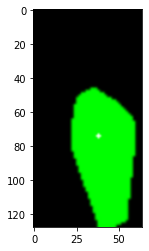

In [596]:
h, w, _ = at_map.shape
aspect_ratio = h/w
scale = 1.4
new_w = int(w * scale)
new_h = int(new_w * aspect_ratio)
new_at_map = cv2.resize(at_map, (new_w, new_h))
new_center = (polygon_center*scale).astype(int)
cv2.circle(new_at_map, tuple(new_center), 1, (255,255,255), thickness=-1)
%pylab inline
plt.imshow(new_at_map[(new_center[1]-up_offset):(new_center[1]+down_offset), (new_center[0]-left_offset):(new_center[0]+right_offset), :], interpolation='bicubic')
plt.show()

In [538]:
polygon = scipy.spatial.ConvexHull(person_coords)

In [540]:
person_coords[polygon.vertices]

array([[ 40, 114],
       [ 23,  71],
       [ 26,  59],
       [ 31,  45],
       [ 37,  40],
       [ 45,  40],
       [ 52,  46],
       [ 62,  60],
       [ 62,  72]])

In [476]:
len(effective_img)

0

In [519]:
a = np.array(at_maps)

In [520]:
b = a[9630]

In [522]:
b.reshape(-1)

array([0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0])

In [312]:
b = np.expand_dims(a[0], 0)

In [523]:
import torch
c = torch.from_numpy(b.reshape(-1))

In [524]:
c

tensor([0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
        0, 0, 1, 1, 1, 1, 1, 0])

In [516]:
d = torch.rand(3,1,16,8)

In [389]:
m = torch.max(d.view(3,-1), dim=1)[0].view(-1,1)

In [390]:
m

tensor([[0.9979],
        [0.9811],
        [0.9662]])

In [395]:
dd = m.expand(3,128).view_as(d)

In [408]:
select = torch.Tensor([0,1,1])==1
d[select]

torch.Size([2, 1, 16, 8])

In [493]:
d = torch.rand(3,1,16,8)
e = torch.rand(3,256,16,8)

In [495]:
d_v = d.reshape(3,-1)
e_v = d.reshape(3,-1)

In [499]:
d_v[d_v>0.5] = 1
d_v[d_v<=0.5] = 0


In [500]:
d_v

tensor([[1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
         1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1.,
         0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
         0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
         1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1.,
         0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1.,
         1., 0.],
        [1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0.,
         1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0.,
         0., 0., 0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.,
         1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1.,
         1

In [492]:
bce = torch.nn.BCEWithLogitsLoss()

In [501]:
bce(e_v, d_v)

tensor(0.4923)

In [488]:
e.sum(dim=1, keepdim=True).shape

torch.Size([3, 1, 16, 8])

In [491]:
(e*e).shape

torch.Size([3, 256, 16, 8])

In [340]:
torch.sum(e[0])

tensor(43.4248)

In [514]:
np.save("/media/allen/mass/reid/dukemtmc-reid/DukeMTMC-reID/at_maps.npy", a)

In [703]:
from PIL import Image
import torchvision.transforms.functional as F
import torchvision.transforms as T
resize = T.Resize(size=(256,128), interpolation=Image.NEAREST)
downsample = T.Resize(size=(16, 8), interpolation=Image.NEAREST)
at_map = Image.open("/media/allen/mass/reid/dukemtmc-reid/DukeMTMC-reID/att_map_gt/0001_c2_f0046182.jpg")
at_map = resize(at_map)
a = torch.Tensor(np.array(at_map)).transpose(0,2).transpose(1,2)
a = a.transpose(0,2).transpose(0,1).numpy()
a = cv2.resize(a, (8, 16)).mean(axis=2)
a = torch.Tensor(a)

In [704]:
a

tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 1., 1., 0., 0.],
        [0., 0., 1., 1., 1., 1., 1., 1.],
        [0., 1., 1., 1., 1., 1., 1., 1.],
        [0., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 1., 1., 1., 1., 1., 1., 1.],
        [0., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1., 1., 1., 1.]])

In [666]:
a = cv2.imread("/media/allen/mass/reid/dukemtmc-reid/DukeMTMC-reID/att_map_gt/0001_c2_f0046182.jpg")

In [671]:
cv2.resize(a, (8, 16)).mean(axis=2)

array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 1., 1., 1., 0., 0.],
       [0., 0., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1., 1., 1.]])

In [650]:
src = "/media/allen/mass/reid/dukemtmc-reid/DukeMTMC-reID/att_map_gt/"
imgs_path = sorted([os.path.join(root, f) for root, _, files in os.walk(src) for f in files if '.jpg' in f or '.png' in f])
with open("/media/allen/mass/reid/dukemtmc-reid/DukeMTMC-reID/at_maps.txt", 'w') as f:
    for path in imgs_path:
        path = path.split("/")[-1]
        f.write("{}\n".format(path))

In [304]:
with open("/media/allen/mass/reid/dukemtmc-reid/DukeMTMC-reID/at_maps.txt", 'r') as f:
    for i, line in enumerate(f):
        line = line.strip()
        print(line, i)

0001_c2_f0046182.jpg 0
0001_c2_f0046302.jpg 1
0001_c2_f0046422.jpg 2
0001_c2_f0046542.jpg 3
0001_c2_f0046662.jpg 4
0001_c2_f0046782.jpg 5
0001_c2_f0046902.jpg 6
0001_c5_f0051367.jpg 7
0001_c5_f0051487.jpg 8
0001_c5_f0051607.jpg 9
0001_c5_f0051727.jpg 10
0001_c5_f0051847.jpg 11
0001_c6_f0030329.jpg 12
0001_c6_f0030449.jpg 13
0001_c6_f0030569.jpg 14
0001_c6_f0030689.jpg 15
0001_c6_f0030809.jpg 16
0001_c6_f0030929.jpg 17
0001_c6_f0031049.jpg 18
0008_c1_f0044158.jpg 19
0008_c1_f0044278.jpg 20
0008_c2_f0048237.jpg 21
0008_c2_f0048477.jpg 22
0008_c2_f0048597.jpg 23
0008_c2_f0048717.jpg 24
0008_c2_f0048837.jpg 25
0008_c2_f0048957.jpg 26
0008_c2_f0049077.jpg 27
0008_c2_f0049197.jpg 28
0008_c3_f0026198.jpg 29
0008_c3_f0026318.jpg 30
0008_c3_f0026438.jpg 31
0008_c3_f0026558.jpg 32
0008_c3_f0026678.jpg 33
0008_c3_f0026798.jpg 34
0008_c4_f0024244.jpg 35
0008_c4_f0024364.jpg 36
0008_c4_f0024484.jpg 37
0008_c4_f0024604.jpg 38
0008_c4_f0024724.jpg 39
0008_c4_f0025084.jpg 40
0013_c1_f0047546.jpg 41
00

0202_c4_f0053428.jpg 1558
0202_c4_f0053548.jpg 1559
0202_c4_f0053788.jpg 1560
0202_c4_f0053908.jpg 1561
0202_c4_f0054028.jpg 1562
0202_c4_f0054148.jpg 1563
0202_c4_f0054388.jpg 1564
0202_c5_f0090000.jpg 1565
0202_c5_f0090120.jpg 1566
0202_c5_f0090360.jpg 1567
0203_c1_f0089833.jpg 1568
0203_c1_f0089953.jpg 1569
0203_c1_f0090073.jpg 1570
0203_c1_f0090193.jpg 1571
0203_c1_f0090313.jpg 1572
0203_c1_f0090433.jpg 1573
0203_c1_f0090673.jpg 1574
0203_c2_f0087265.jpg 1575
0203_c2_f0087625.jpg 1576
0203_c2_f0087745.jpg 1577
0203_c2_f0087865.jpg 1578
0203_c2_f0087985.jpg 1579
0203_c2_f0088105.jpg 1580
0203_c2_f0088225.jpg 1581
0203_c2_f0088465.jpg 1582
0203_c2_f0088585.jpg 1583
0203_c2_f0088825.jpg 1584
0203_c2_f0088945.jpg 1585
0203_c2_f0089065.jpg 1586
0203_c2_f0089185.jpg 1587
0203_c2_f0089305.jpg 1588
0203_c2_f0089545.jpg 1589
0208_c1_f0090171.jpg 1590
0208_c1_f0090291.jpg 1591
0208_c1_f0090411.jpg 1592
0208_c1_f0090531.jpg 1593
0208_c1_f0090651.jpg 1594
0208_c1_f0090771.jpg 1595
0208_c1_f009

0366_c2_f0109474.jpg 2730
0366_c2_f0109594.jpg 2731
0366_c2_f0109714.jpg 2732
0366_c2_f0109954.jpg 2733
0366_c3_f0085027.jpg 2734
0366_c3_f0085147.jpg 2735
0368_c6_f0075710.jpg 2736
0368_c6_f0076070.jpg 2737
0368_c6_f0076310.jpg 2738
0368_c6_f0076550.jpg 2739
0368_c7_f0078047.jpg 2740
0368_c7_f0078527.jpg 2741
0368_c8_f0048459.jpg 2742
0368_c8_f0048579.jpg 2743
0368_c8_f0048699.jpg 2744
0368_c8_f0048819.jpg 2745
0368_c8_f0048939.jpg 2746
0370_c1_f0109546.jpg 2747
0370_c1_f0109666.jpg 2748
0370_c1_f0109786.jpg 2749
0370_c1_f0109906.jpg 2750
0370_c1_f0110026.jpg 2751
0370_c1_f0110146.jpg 2752
0370_c2_f0113808.jpg 2753
0370_c2_f0113928.jpg 2754
0370_c2_f0114408.jpg 2755
0370_c3_f0091149.jpg 2756
0370_c3_f0091269.jpg 2757
0370_c3_f0091389.jpg 2758
0370_c3_f0091509.jpg 2759
0370_c4_f0088717.jpg 2760
0370_c4_f0088837.jpg 2761
0373_c1_f0110010.jpg 2762
0373_c1_f0110130.jpg 2763
0373_c1_f0110250.jpg 2764
0373_c1_f0110370.jpg 2765
0373_c2_f0114016.jpg 2766
0373_c2_f0114256.jpg 2767
0373_c2_f011

0568_c6_f0129550.jpg 4291
0568_c6_f0129670.jpg 4292
0568_c6_f0129790.jpg 4293
0568_c6_f0129910.jpg 4294
0569_c1_f0150831.jpg 4295
0569_c1_f0150951.jpg 4296
0569_c1_f0151071.jpg 4297
0569_c1_f0151191.jpg 4298
0569_c1_f0151311.jpg 4299
0569_c1_f0151431.jpg 4300
0569_c2_f0154827.jpg 4301
0569_c2_f0155067.jpg 4302
0569_c2_f0155187.jpg 4303
0569_c2_f0155307.jpg 4304
0569_c3_f0132168.jpg 4305
0569_c3_f0132288.jpg 4306
0569_c3_f0132408.jpg 4307
0569_c3_f0132528.jpg 4308
0569_c4_f0129546.jpg 4309
0569_c4_f0129666.jpg 4310
0569_c4_f0129906.jpg 4311
0569_c4_f0130026.jpg 4312
0572_c1_f0151091.jpg 4313
0572_c1_f0151211.jpg 4314
0572_c1_f0151331.jpg 4315
0572_c1_f0151451.jpg 4316
0572_c1_f0151571.jpg 4317
0572_c1_f0151691.jpg 4318
0572_c1_f0151811.jpg 4319
0572_c8_f0107272.jpg 4320
0572_c8_f0107392.jpg 4321
0572_c8_f0107512.jpg 4322
0573_c1_f0151518.jpg 4323
0573_c1_f0151638.jpg 4324
0573_c1_f0151758.jpg 4325
0573_c1_f0151878.jpg 4326
0573_c1_f0151998.jpg 4327
0573_c2_f0155327.jpg 4328
0573_c2_f015

0739_c2_f0185865.jpg 5800
0739_c2_f0186105.jpg 5801
0739_c2_f0186225.jpg 5802
0740_c1_f0185760.jpg 5803
0740_c1_f0185880.jpg 5804
0740_c1_f0186000.jpg 5805
0740_c1_f0186120.jpg 5806
0740_c1_f0186240.jpg 5807
0740_c1_f0186360.jpg 5808
0740_c2_f0189883.jpg 5809
0740_c2_f0190123.jpg 5810
0740_c2_f0190363.jpg 5811
0740_c2_f0190603.jpg 5812
0744_c1_f0187024.jpg 5813
0744_c1_f0187144.jpg 5814
0744_c1_f0187264.jpg 5815
0744_c1_f0187384.jpg 5816
0744_c1_f0187504.jpg 5817
0744_c1_f0187624.jpg 5818
0744_c2_f0187077.jpg 5819
0744_c2_f0187557.jpg 5820
0744_c2_f0187677.jpg 5821
0744_c3_f0162516.jpg 5822
0744_c3_f0162756.jpg 5823
0744_c3_f0162996.jpg 5824
0744_c4_f0157552.jpg 5825
0744_c4_f0157672.jpg 5826
0745_c1_f0187054.jpg 5827
0745_c1_f0187174.jpg 5828
0745_c1_f0187294.jpg 5829
0745_c1_f0187414.jpg 5830
0745_c1_f0187534.jpg 5831
0745_c1_f0187654.jpg 5832
0745_c1_f0187774.jpg 5833
0745_c2_f0187086.jpg 5834
0745_c2_f0187326.jpg 5835
0745_c2_f0187446.jpg 5836
0745_c3_f0162645.jpg 5837
0745_c3_f016

1532_c3_f0083035.jpg 7194
1532_c4_f0080207.jpg 7195
1532_c4_f0080327.jpg 7196
1532_c4_f0080447.jpg 7197
1532_c4_f0080807.jpg 7198
1532_c4_f0080927.jpg 7199
1542_c2_f0105598.jpg 7200
1542_c2_f0105718.jpg 7201
1542_c2_f0105838.jpg 7202
1542_c2_f0105958.jpg 7203
1542_c2_f0106078.jpg 7204
1542_c2_f0106198.jpg 7205
1542_c2_f0106318.jpg 7206
1542_c2_f0106438.jpg 7207
1542_c2_f0106558.jpg 7208
1542_c2_f0106678.jpg 7209
1542_c8_f0061256.jpg 7210
1542_c8_f0061376.jpg 7211
1559_c2_f0108702.jpg 7212
1559_c2_f0108822.jpg 7213
1559_c2_f0108942.jpg 7214
1559_c2_f0109062.jpg 7215
1559_c2_f0109182.jpg 7216
1559_c2_f0109302.jpg 7217
1559_c2_f0109782.jpg 7218
1559_c2_f0109902.jpg 7219
1559_c2_f0110022.jpg 7220
1559_c2_f0110382.jpg 7221
1559_c2_f0110502.jpg 7222
1559_c2_f0110862.jpg 7223
1559_c2_f0110982.jpg 7224
1559_c2_f0111222.jpg 7225
1559_c2_f0111462.jpg 7226
1559_c2_f0111582.jpg 7227
1559_c2_f0111702.jpg 7228
1559_c2_f0111822.jpg 7229
1559_c2_f0112062.jpg 7230
1559_c2_f0112182.jpg 7231
1559_c2_f011

3619_c5_f0149128.jpg 8600
3619_c5_f0149248.jpg 8601
3619_c5_f0149368.jpg 8602
3619_c5_f0149608.jpg 8603
3619_c6_f0128301.jpg 8604
3619_c6_f0128421.jpg 8605
3619_c6_f0128541.jpg 8606
3619_c6_f0128661.jpg 8607
3619_c6_f0128781.jpg 8608
3619_c6_f0128901.jpg 8609
3621_c4_f0093499.jpg 8610
3621_c4_f0093739.jpg 8611
3621_c4_f0093859.jpg 8612
3621_c4_f0094099.jpg 8613
3621_c4_f0094219.jpg 8614
3621_c4_f0094339.jpg 8615
3621_c4_f0094459.jpg 8616
3621_c4_f0094579.jpg 8617
3621_c5_f0128485.jpg 8618
3621_c5_f0128605.jpg 8619
3621_c5_f0128725.jpg 8620
3621_c5_f0128845.jpg 8621
3621_c5_f0128965.jpg 8622
3621_c5_f0151978.jpg 8623
3621_c5_f0152098.jpg 8624
3621_c5_f0152218.jpg 8625
3621_c5_f0152338.jpg 8626
3621_c5_f0152458.jpg 8627
3621_c5_f0152578.jpg 8628
3621_c5_f0152698.jpg 8629
3621_c5_f0152818.jpg 8630
3680_c5_f0173074.jpg 8631
3680_c5_f0173194.jpg 8632
3680_c5_f0173314.jpg 8633
3680_c5_f0173434.jpg 8634
3680_c6_f0151882.jpg 8635
3680_c6_f0152002.jpg 8636
3680_c6_f0152122.jpg 8637
3680_c6_f015

4412_c6_f0092723.jpg 9861
4412_c6_f0093083.jpg 9862
4412_c6_f0093203.jpg 9863
4412_c6_f0093323.jpg 9864
4412_c6_f0093443.jpg 9865
4412_c7_f0094988.jpg 9866
4412_c7_f0095108.jpg 9867
4412_c7_f0095228.jpg 9868
4412_c7_f0095348.jpg 9869
4412_c7_f0095468.jpg 9870
4412_c7_f0095588.jpg 9871
4415_c6_f0093860.jpg 9872
4415_c6_f0094100.jpg 9873
4415_c6_f0094220.jpg 9874
4415_c6_f0094460.jpg 9875
4415_c7_f0095972.jpg 9876
4415_c7_f0096332.jpg 9877
4415_c7_f0096452.jpg 9878
4415_c7_f0096572.jpg 9879
4415_c7_f0096692.jpg 9880
4415_c7_f0096812.jpg 9881
4415_c8_f0066396.jpg 9882
4415_c8_f0066516.jpg 9883
4415_c8_f0066756.jpg 9884
4415_c8_f0066876.jpg 9885
4415_c8_f0066996.jpg 9886
4417_c6_f0093986.jpg 9887
4417_c6_f0094346.jpg 9888
4417_c6_f0094466.jpg 9889
4417_c6_f0094706.jpg 9890
4417_c6_f0094826.jpg 9891
4417_c6_f0094946.jpg 9892
4417_c6_f0095066.jpg 9893
4417_c7_f0096404.jpg 9894
4417_c7_f0096524.jpg 9895
4417_c7_f0096644.jpg 9896
4417_c7_f0096764.jpg 9897
4417_c7_f0096884.jpg 9898
4417_c8_f006

5388_c6_f0150642.jpg 11135
5388_c6_f0150762.jpg 11136
5388_c6_f0151482.jpg 11137
5388_c6_f0151962.jpg 11138
5388_c6_f0152082.jpg 11139
5388_c6_f0152442.jpg 11140
5388_c6_f0152562.jpg 11141
5388_c6_f0152682.jpg 11142
5388_c6_f0152802.jpg 11143
5388_c6_f0152922.jpg 11144
5388_c6_f0153042.jpg 11145
5388_c6_f0153162.jpg 11146
5388_c6_f0153402.jpg 11147
5388_c6_f0154758.jpg 11148
5388_c6_f0154878.jpg 11149
5388_c6_f0154998.jpg 11150
5388_c6_f0155118.jpg 11151
5388_c6_f0155238.jpg 11152
5388_c6_f0155358.jpg 11153
5388_c6_f0155478.jpg 11154
5388_c6_f0155598.jpg 11155
5388_c6_f0155718.jpg 11156
5388_c6_f0155838.jpg 11157
5388_c6_f0156078.jpg 11158
5388_c6_f0156318.jpg 11159
5388_c6_f0156558.jpg 11160
5388_c6_f0156678.jpg 11161
5388_c6_f0156918.jpg 11162
5388_c6_f0157038.jpg 11163
5388_c6_f0157158.jpg 11164
5388_c6_f0157278.jpg 11165
5388_c6_f0157398.jpg 11166
5388_c6_f0157518.jpg 11167
5388_c6_f0170458.jpg 11168
5388_c6_f0170578.jpg 11169
5388_c6_f0170698.jpg 11170
5388_c6_f0171298.jpg 11171
5

In [532]:
a = np.load("/media/allen/mass/reid/dukemtmc-reid/DukeMTMC-reID/at_maps.npy",dtype=int)

TypeError: load() got an unexpected keyword argument 'dtype'

In [533]:
a[108]

array([[0., 1., 1., 1., 1., 1., 1., 0.],
       [0., 1., 1., 1., 1., 1., 1., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1., 1., 0.],
       [0., 1., 1., 1., 1., 1., 1., 0.]])

In [281]:
img.shape[:2]

(204, 61)

Populating the interactive namespace from numpy and matplotlib


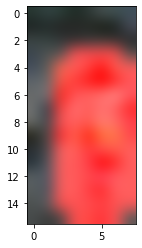

In [473]:
def gaussian(kernel):
    sigma = kernel*0.35
    s = 2*(sigma**2)
    dx = np.exp(-np.square(np.arange(kernel) - int(kernel / 2)) / s)
    return np.reshape(dx,(-1,1))

dx = gaussian(x2-x1)
dy = gaussian(y2-y1)
gau_map = np.multiply(dy, np.transpose(dx))
gau_map[gau_map<0.25] = 0
gau_map[gau_map>0.25] = 1
at_map = np.zeros_like(canvas)

at_map[y1:y2, x1:x2, 0] = gau_map * 255

added_image = cv2.addWeighted(at_map,1,canvas,0.6,0)
added_image = cv2.resize(added_image, (8,16))

%pylab inline
plt.imshow(added_image, interpolation='bicubic')
plt.show()

In [439]:
gau_map[0]

array([0.13278951, 0.13861633, 0.14456233, 0.15062115, 0.15678586,
       0.16304892, 0.1694022 , 0.17583699, 0.18234404, 0.18891349,
       0.19553498, 0.20219763, 0.20889005, 0.21560039, 0.22231637,
       0.22902528, 0.23571406, 0.24236933, 0.2489774 , 0.25552435,
       0.26199606, 0.26837825, 0.27465655, 0.28081656, 0.28684386,
       0.29272411, 0.29844309, 0.30398676, 0.30934129, 0.31449317,
       0.31942921, 0.32413666, 0.32860318, 0.33281697, 0.3367668 ,
       0.34044202, 0.34383268, 0.34692951, 0.349724  , 0.3522084 ,
       0.35437583, 0.35622022, 0.3577364 , 0.35892011, 0.35976802,
       0.36027773, 0.36044779, 0.36027773, 0.35976802, 0.35892011,
       0.3577364 , 0.35622022, 0.35437583, 0.3522084 , 0.349724  ,
       0.34692951, 0.34383268, 0.34044202, 0.3367668 , 0.33281697,
       0.32860318, 0.32413666, 0.31942921, 0.31449317, 0.30934129,
       0.30398676, 0.29844309, 0.29272411, 0.28684386, 0.28081656,
       0.27465655, 0.26837825, 0.26199606, 0.25552435, 0.24897

In [191]:
temp = added_image
temp = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)    
pil_img = Image.fromarray(temp)
pil_img

In [112]:
person_coords[polygon.vertices]

array([[ 34, 106],
       [ 12,  98],
       [ 29,  37],
       [ 43,  18],
       [ 60,  23],
       [ 55,  44]])

In [60]:
from sklearn.decomposition import PCA
X = person_coords
pca = PCA(n_components=2)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [75]:
cov = np.cov(X.transpose())
eigen = np.linalg.eig(cov)

In [100]:
import scipy
# X = person_coords.transpose()
X = np.array([[1,1],[-2,2]])
scipy.linalg.orth(X)

array([[5.07150507e-17, 1.00000000e+00],
       [1.00000000e+00, 2.11388036e-16]])

In [49]:
pca.get_params()

{'copy': True,
 'iterated_power': 'auto',
 'n_components': 2,
 'random_state': None,
 'svd_solver': 'auto',
 'tol': 0.0,
 'whiten': False}

In [35]:
np.mean(person_coords, axis=0, dtype=int)

array([39, 52])

In [39]:
person_coords[:,1].mean()

52.285714285714285

In [9]:
candidate[:,2]

array([0.92522347, 0.84664989, 0.7786153 , 0.59888989, 0.59151649,
       0.12263605, 0.79071629, 0.668486  , 0.54057485, 0.54057485,
       0.10184604, 0.63376194, 0.28609326, 0.5477339 , 0.14803836,
       0.75227845, 0.93494886, 0.81585717])

In [32]:
(x2 - x1)*0.25

11.75

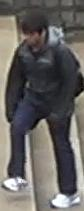

In [30]:
temp = to_plot
temp = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)    
pil_img = Image.fromarray(temp)
pil_img

In [378]:
os.path.join(dst, path.split("/")[-1])

'/media/allen/mass/reid/market1501_align/bounding_box_train/0002_c2s1_000301_01.jpg'

In [353]:
from scipy.spatial import ConvexHull

13
9
4
0
14
15
5
6
10


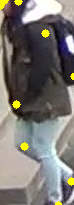

In [375]:
trans_person_coords = person_coords - np.array([x1, y1])
hull = ConvexHull(trans_person_coords)
temp_clean = to_plot[y1:y2, x1:x2, :]
for idx in hull.vertices:
    print(idx)
    cv2.circle(temp_clean, tuple(trans_person_coords[idx].astype(
                    int)), 4, (0,255,255), thickness=-1)
temp_clean = cv2.cvtColor(temp_clean, cv2.COLOR_BGR2RGB)    
pil_img = Image.fromarray(temp_clean)
pil_img

In [343]:
pts = find_part(subset[0], candidate, BODY)

In [344]:
order = np.argsort(pts[:,1], axis=0)
x_mean = np.mean(pts[:,0])
left = []
right = []
for idx in order:
    if pts[idx][0] < x_mean:
        left.append(pts[idx])
    else:
        right.append(pts[idx])
ordered_pts = np.array(left + right)

In [345]:
maxWidth = np.max(ordered_pts[:,0]) - np.min(ordered_pts[:,0])
maxHeight = np.max(ordered_pts[:,1]) - np.min(ordered_pts[:,1])
dst = np.array([
		[0, 0],
		[0, int(maxHeight/2)-1],
		[0, maxHeight - 1],
		[maxWidth - 1, 0],
        [int(maxWidth/2)-1, int(maxHeight/2)-1],
        [maxWidth - 1, maxHeight - 1]], dtype = "float32")
h, status = cv2.findHomography(ordered_pts, dst)
warped = cv2.warpPerspective(to_plot, h, (maxWidth, maxHeight))

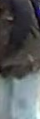

In [346]:
temp = warped
temp = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)    
pil_img = Image.fromarray(temp)
pil_img

In [132]:
PERSON = {'nose': 0,
          'l_eye': 15, 'r_eye': 14, 
          'l_ear': 17, 'r_ear': 16, 
          'neck': 1, 
          'l_s': 5, 'r_s': 2, 
          'l_e': 6, 'r_e': 3, 
          'l_h': 11, 'r_h': 8, 
          'l_k': 12, 'r_k': 9, 
          'l_a': 13, 'r_a': 10}

In [318]:
BODY = set([2,8,9,5,11,12])
ARM1 = set([5,6])
ARM2 = set([2,3])
THIGH1 = set([11,12])
THIGH2 = set([8,9])
DETECT = [BODY, ARM1, ARM2, THIGH1, THIGH2]

In [258]:
def find_part(person, joints, part):
    coords = []
    info = set()
    for joint in part:
        index = int(person[joint])
        if index < 0: continue
        info.add(joint)
        coords.append((joints[index][:2]).astype(int))
    if len(info) > len(part)/2:
        return np.array(coords)
    else: 
        return None
    
def get_four_pts(pts, part, r=10):   
    if part == 'body':
        if pts.shape[0] != 4:
            x1 = np.min(pts[:,0])
            y1 = np.min(pts[:,1])
            x2 = np.max(pts[:,0])
            y2 = np.max(pts[:,1])
            four_pts = np.array([[x1,y1],
                                 [x1,y2],
                                 [x2,y1],
                                 [x2,y2]], dtype=int) 
        else:
            four_pts = pts
    if part == 'arm' or part == 'thigh':
        x1, y1 = pts[0]
        x2, y2 = pts[1]
        four_pts = np.array([[x1+r,y1],
                             [x1-r,y1],
                             [x2+r,y2],
                             [x2-r,y2]], dtype=int)   
    return four_pts

In [152]:
import numpy as np
import cv2
 
def order_points(pts):
	# initialzie a list of coordinates that will be ordered
	# such that the first entry in the list is the top-left,
	# the second entry is the top-right, the third is the
	# bottom-right, and the fourth is the bottom-left
	rect = np.zeros((4, 2), dtype = "float32")
 
	# the top-left point will have the smallest sum, whereas
	# the bottom-right point will have the largest sum
	s = pts.sum(axis = 1)
	rect[0] = pts[np.argmin(s)]
	rect[2] = pts[np.argmax(s)]
 
	# now, compute the difference between the points, the
	# top-right point will have the smallest difference,
	# whereas the bottom-left will have the largest difference
	diff = np.diff(pts, axis = 1)
	rect[1] = pts[np.argmin(diff)]
	rect[3] = pts[np.argmax(diff)]
 
	# return the ordered coordinates
	return rect


In [160]:
def four_point_transform(image, pts, w=None, h=None):
	# obtain a consistent order of the points and unpack them
	# individually
	rect = order_points(pts)
	(tl, tr, br, bl) = rect
 
	# compute the width of the new image, which will be the
	# maximum distance between bottom-right and bottom-left
	# x-coordiates or the top-right and top-left x-coordinates
	widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
	widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
	maxWidth = max(int(widthA), int(widthB)) if w is None else w
 
	# compute the height of the new image, which will be the
	# maximum distance between the top-right and bottom-right
	# y-coordinates or the top-left and bottom-left y-coordinates
	heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
	heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
	maxHeight = max(int(heightA), int(heightB)) if h is None else h
 
	# now that we have the dimensions of the new image, construct
	# the set of destination points to obtain a "birds eye view",
	# (i.e. top-down view) of the image, again specifying points
	# in the top-left, top-right, bottom-right, and bottom-left
	# order
	dst = np.array([
		[0, 0],
		[maxWidth - 1, 0],
		[maxWidth - 1, maxHeight - 1],
		[0, maxHeight - 1]], dtype = "float32")
 
	# compute the perspective transform matrix and then apply it
	M = cv2.getPerspectiveTransform(rect, dst)
	warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
 
	# return the warped image
	return warped

In [299]:
body_coords = find_part(subset[0], candidate, BODY)
if body_coords is not None:
    four_pts = get_four_pts(body_coords, 'body')
    warped = four_point_transform(to_plot, four_pts, 200, 200)
    temp = warped
    temp = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)    
    pil_img = Image.fromarray(temp)
    pil_img.show()

In [307]:
four_pts

array([[ 56, 148],
       [ 36, 148],
       [ 51, 188],
       [ 31, 188]])

In [294]:
four

(270, 107, 3)

In [302]:
detect = ['body', 'arm', 'arm', 'thigh', 'thigh']
pil_imgs = []
for part, PART in zip(detect, DETECT):
    body_coords = find_part(subset[0], candidate, PART)
    if body_coords is not None:
        four_pts = get_four_pts(body_coords, part, r=10)
        warped = four_point_transform(to_plot, four_pts, to_plot.shape[1], np.max(four_pts[:,1]) - np.min(four_pts[:,1]))
        temp = warped
        temp = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)    
        pil_img = Image.fromarray(temp)
        pil_imgs.append(pil_img)

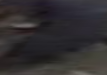

In [308]:
pil_imgs[0]

In [253]:
four_pts

array([[302, 218],
       [300, 218],
       [285, 294],
       [283, 294]])

In [201]:
temp = to_plot[four_pts[0][1]:four_pts[3][1], four_pts[0][1]:four_pts[3][1], :]
temp = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)    
pil_img = Image.fromarray(temp)
pil_img

In [75]:

person_part = {}
person_info = {}    
for part in DETECT.keys():
    joints_coord = []    
    info = set()
    for joint in DETECT[part]:
        index = int(subset[0][joint])
        if index < 0: continue
        info.add(part)
        joints_coord.append((candidate[index][:2]).astype(int))
    joints_coord = np.array(joints_coord)
        
    if part == 'body':       
        if len(info) > 1:
            if set.intersection(set(2,11), info) or set.intersection(set(5,8), info):
                # find max and min coord in x-axis and y-axis 
                x1 = np.min(joints_coord[:,0])
                y1 = np.min(joints_coord[:,1])
                x2 = np.max(joints_coord[:,0])
                y2 = np.max(joints_coord[:,1])
                joints_coord = np.array([[x1,y1],
                                         [x1,y2],
                                         [x2,y1],
                                         [x2,y2]], dtype=int)                
            elif set.intersection(set(2,8), info) or set.intersection(set(5,11), info):
                # assume that side of person is seen, add points by looking horizontally
                x1, y1 = joints_coord[0]
                x2, y2 = joints_coord[1]
                joints_coord = np.array([[x1+r,y1],
                                         [x1-r,y1],
                                         [x2+r,y2],
                                         [x2-r,y2]], dtype=int)   
            elif set.intersection(set(2,5), info):
                # assume that upper body is seen, add points by looking downward
                if appearance['thigh']:
                x1, y1 = joints_coord[0]
                x2, y2 = joints_coord[1]
                joints_coord = np.array([[x1,y1],
                                         [x1,y1+r],
                                         [x2,y2],
                                         [x2,y2+r]], dtype=int)   
            elif set.intersection(set(5,11), info):
                # assume that lower body is seen, add points by looking upward
                if 
                x1, y1 = joints_coord[0]
                x2, y2 = joints_coord[1]
                joints_coord = np.array([[x1,y1],
                                         [x1,y1-r],
                                         [x2,y2],
                                         [x2,y2-r]], dtype=int) 
                
        else:
            person_info['body'] = False
    
    elif part == 'arm':
        if len(info) > 1:
            if set.intersection(set(2,3), info) or set.intersection(set(5,6), info):
                # assume that arm is seen, add points by looking horizontally
        else:
            person_info['arm'] = False
    elif part == 'thigh':
        if len(info) > 1:
            if set.intersection(set(8,9), info) or set.intersection(set(11,12), info):
                # assume that thigh is seen, add points by looking horizontally
        else:
            person_info['thigh'] = False
    
    person_part[part] = joints_coord
            
    
    
    
    
    
    
    
    
    
    if part == 'body':
        break
    if part == 'head':
        center = np.mean(joints_coord, axis=0).astype(int)
        x1, y1, x2, y2 = center[0] - 20, center[1] - 20, center[0] + 20, center[1] + 20
    else:
        x1 = np.min(joints_coord[:,0]) - r
        y1 = np.min(joints_coord[:,1]) - r
        x2 = np.max(joints_coord[:,0]) + r
        y2 = np.max(joints_coord[:,1]) + r

    part = to_plot[y1:y2, x1:x2,:]
    temp = part
    temp = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)    
    pil_img = Image.fromarray(temp)
    person_img.append(pil_img)

head
body


In [55]:
joints_coord

array([[ 37,  51],
       [ 64,  50],
       [ 40, 112],
       [ 64, 114]])

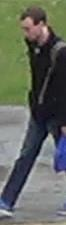

In [58]:
temp = to_plot
temp = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)    
pil_img = Image.fromarray(temp)
pil_img

In [76]:
y1 = np.min(joints_coord[:,1])
y2 = np.max(joints_coord[:,1])

In [148]:
joints_coord

array([[ 47, 196],
       [ 62, 200]])

In [87]:
warped.shape

(135, 108, 3)

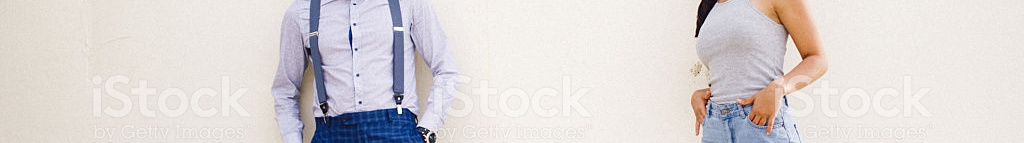

In [82]:
temp = to_plot[y1:y2,:,:]
temp = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)    
pil_img = Image.fromarray(temp)
pil_img

In [55]:
r = 5
l_thigh_x_a, l_thigh_y_a = (candidate[int(subset[1][LTHIGH[0]])][:2] - r).astype(int)
l_thigh_x_b, l_thigh_y_b = (candidate[int(subset[1][LTHIGH[1]])][:2] + r).astype(int)

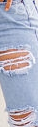

In [57]:
l_thigh = to_plot[l_thigh_y_a:l_thigh_y_b, l_thigh_x_a:l_thigh_x_b,:]
temp = l_thigh
temp = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)    
pil_img = Image.fromarray(temp)
pil_img

In [6]:
len(final)

6

In [11]:
len(candidate)

51

In [ ]:
p0 = list(range(18))
p1 = [0,1,2,5,14,15,16,17]
p2 = [1,2,3,4,5,6,7,8,11]
p3 = [8,9,10,11,12,13]
p4 = [9,10,12,13]

In [59]:

def _extract_region(person, candidate, region):
    region_info = []
    for i in region:
        joint_index = person[i].astype(int)
        if joint_index == -1:
            continue
        joint_coord = candidate[joint_index, 0:2]
        joint_prob = np.array(candidate[joint_index, 2])
        # if joint_prob < 0.5:
        #     continue
        region_info.append(np.hstack([joint_coord, joint_prob]))
    return np.array(region_info)

In [76]:
whole_body = [14,15,16,17,2,5,8,11,10,13,9,12,3,4,6,7]
upper_body = [2,5,8,11,3,4,6,7]
lower_body = [8,9,10,11,12,13]
body = [whole_body, upper_body, lower_body]

In [77]:
groups = {}
for j, person in enumerate(subset):
    groups[j] = {}
    for b, region in enumerate(body):
        extract_region = _extract_region(person, candidate, region)
        if extract_region.shape[0] < len(region) * 0.5:
            groups[j][b] = np.array([])
        else:
            groups[j][b] = extract_region
#     for i in range(18):
#         temp = canvas.copy()
#         joint_index = person[i].astype(int)
#         if joint_index == -1:
#             print(i)
#             continue
#         joint_coord = candidate[joint_index, 0:2]
#         joint_prob = candidate[joint_index, 2]
#         cv2.circle(temp, tuple(joint_coord.astype(
#                         int)), 4, (255,255,255), thickness=-1)  
#         cv2.putText(temp, "{}--{:.2f}".format(i, joint_prob), tuple(joint_coord.astype(
#                 int)), cv2.FONT_HERSHEY_DUPLEX, 0.6, (0,0,0), 1)
#         cv2.imwrite('./results/{}_{}_{}'.format(j, i, path.split("/")[-1]),temp)  

In [80]:
canvas = cv2.imread(imgs_path[0])

from PIL import Image
imgs = []

for idx in groups.keys():
    temp = canvas.copy()
    for body in groups[idx].keys():        
        h, w, _ = temp.shape
        person = groups[idx][body]
        if person.shape[0] > 0:
            x1, y1, x2, y2 = int(np.min(person[:,0])), int(np.min(person[:,1])), int(np.max(person[:,0])), int(np.max(person[:,1]))
            width, height = x2 - x1, y2 - y1
            w_offset, h_offset = int(0.2 * width), int(0.2 * height)
            tlx = x1 - w_offset if x1 - w_offset > 0 else 0
            tly = y1 - h_offset if y1 - h_offset > 0 else 0
            brx = x2 + w_offset if x2 + w_offset < w else w
            bry = y2 + h_offset if y2 + h_offset < h else h

            tl, br = (tlx, tly), (brx, bry)
            cv2.rectangle(temp, tl, br, (255,255,255), 3)
    temp = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)    

    img = Image.fromarray(temp)
    imgs.append(img)

In [87]:
canvas[0].reshape((3,1920)).shape

(3, 1920)

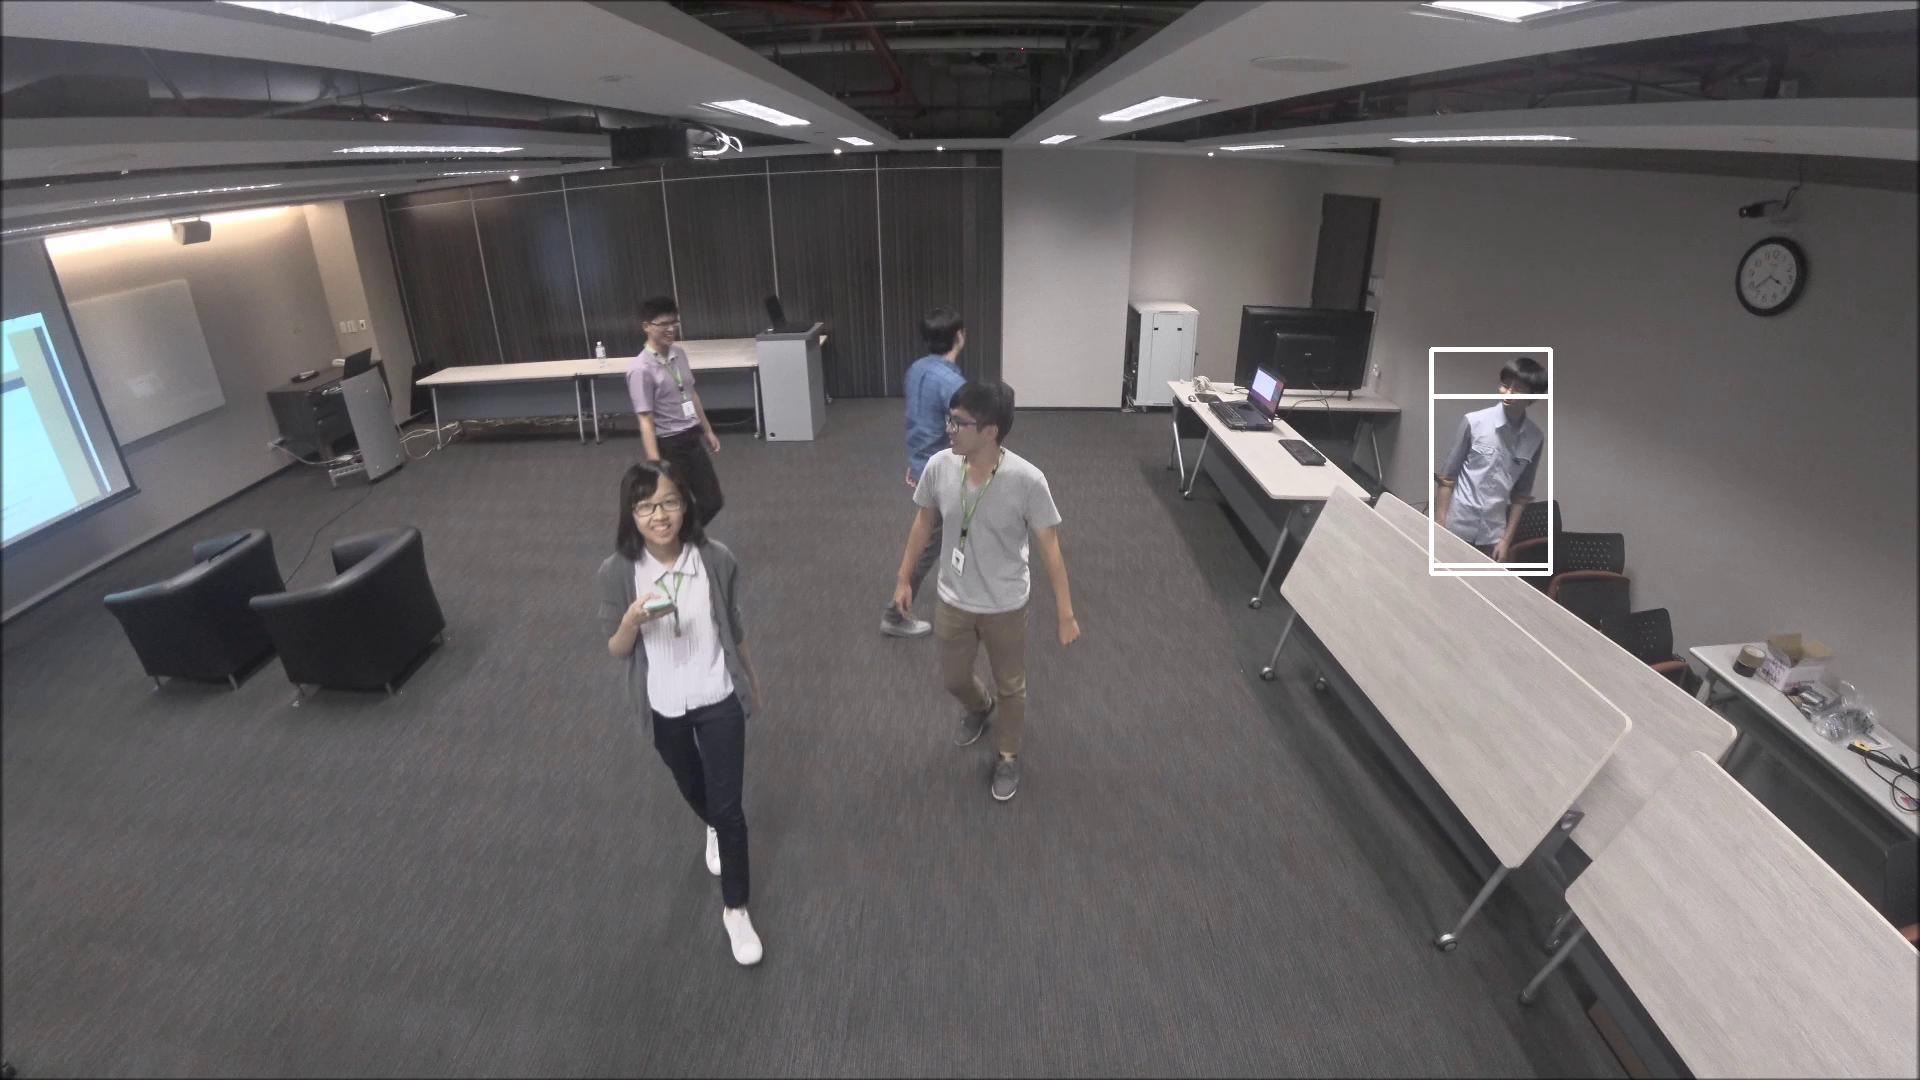

In [84]:
imgs[0]

In [10]:
limb_type = 0

joint_indices = subset[0][joint_to_limb_heatmap_relationship[limb_type]].astype(
                int)
# if -1 in joint_indices:
#     # Only draw actual limbs (connected joints), skip if not
#     # connected
#     continue
# # joint_coords[:,0] represents Y coords of both joints;
# # joint_coords[:,1], X coords
joint_coords = joint_list[joint_indices, 0:2]

joint_probs = joint_list[joint_indices, 2]

In [25]:
joint_to_limb_heatmap_relationship

[[1, 2],
 [1, 5],
 [2, 3],
 [3, 4],
 [5, 6],
 [6, 7],
 [1, 8],
 [8, 9],
 [9, 10],
 [1, 11],
 [11, 12],
 [12, 13],
 [1, 0],
 [0, 14],
 [14, 16],
 [0, 15],
 [15, 17],
 [2, 16],
 [5, 17]]

# Step 1, find joint

In [8]:
from network.post import *
img_orig = oriImg
heatmaps = heatmap
pafs = paf
# Bottom-up approach:
# Step 1: find all joints in the image (organized by joint type: [0]=nose,
# [1]=neck...)
joint_list_per_joint_type = NMS(param, heatmaps, img_orig.shape[0] / float(heatmaps.shape[0]))

### make joint list

In [31]:
# joint_list is an unravel'd version of joint_list_per_joint, where we add
# a 5th column to indicate the joint_type (0=nose, 1=neck...)
joint_list = np.array([tuple(peak) + (joint_type,) for joint_type,
                       joint_peaks in enumerate(joint_list_per_joint_type) for peak in joint_peaks])
for joint_type, joint_peaks in enumerate(joint_list_per_joint_type):
    for peak in joint_peaks:
        print(tuple(peak) + (joint_type,))


(725.0, 144.0, 1.0171940326690674, 0.0, 0)
(380.0, 148.0, 0.7844371199607849, 1.0, 0)
(744.0, 198.0, 0.7570816278457642, 2.0, 1)
(355.0, 209.0, 0.782046914100647, 3.0, 1)
(710.0, 202.0, 0.6346892714500427, 4.0, 2)
(302.0, 216.0, 0.7200198173522949, 5.0, 2)
(708.0, 259.0, 0.15790675580501556, 6.0, 3)
(284.0, 294.0, 0.8061543703079224, 7.0, 3)
(298.0, 359.0, 0.7763283252716064, 8.0, 4)
(778.0, 192.0, 0.7360566258430481, 9.0, 5)
(410.0, 202.0, 0.6123904585838318, 10.0, 5)
(814.0, 261.0, 0.7878525257110596, 11.0, 6)
(451.0, 268.0, 0.5275934934616089, 12.0, 6)
(777.0, 297.0, 0.7071110606193542, 13.0, 7)
(429.0, 330.0, 0.44499948620796204, 14.0, 7)
(718.0, 326.0, 0.4505806863307953, 15.0, 8)
(330.0, 339.0, 0.426766574382782, 16.0, 8)
(338.0, 441.0, 0.2881115972995758, 17.0, 9)
(727.0, 455.0, 0.28143075108528137, 18.0, 9)
(350.0, 542.0, 0.3011082112789154, 19.0, 9)
(343.0, 506.0, 0.1374632865190506, 20.0, 10)
(731.0, 552.0, 0.2514793872833252, 21.0, 10)
(363.0, 617.0, 0.6649921536445618, 22.0

In [6]:
joint_list_per_joint_type[2]

array([[7.10000000e+02, 2.02000000e+02, 6.34689271e-01, 4.00000000e+00],
       [3.02000000e+02, 2.16000000e+02, 7.20019817e-01, 5.00000000e+00]])

# Step 2, Connect joints

In [29]:
# Step 2: find which joints go together to form limbs (which wrists go
# with which elbows)
paf_upsamp = cv2.resize(pafs, (img_orig.shape[1], img_orig.shape[0]), interpolation=cv2.INTER_CUBIC)
connected_limbs = find_connected_joints(param, paf_upsamp, joint_list_per_joint_type)

### 10 points of vector of part affinity field between connected joints is considered

### Auxiliary array to access paf_upsamp quickly

In [ ]:
connected_limbs = []
num_intermed_pts = 10
limb_intermed_coords = np.empty((4, num_intermed_pts), dtype=np.intp)

### consider type 2 and all limb pairs

In [33]:
print(joint_to_limb_heatmap_relationship)

[[1, 2], [1, 5], [2, 3], [3, 4], [5, 6], [6, 7], [1, 8], [8, 9], [9, 10], [1, 11], [11, 12], [12, 13], [1, 0], [0, 14], [14, 16], [0, 15], [15, 17], [2, 16], [5, 17]]


In [35]:
limb_type = 2
# List of all joints of type A found, where A is specified by limb_type
# (eg: a right forearm starts in a right elbow)
joints_src = joint_list_per_joint_type[joint_to_limb_heatmap_relationship[limb_type][0]]
# List of all joints of type B found, where B is specified by limb_type
# (eg: a right forearm ends in a right wrist)
joints_dst = joint_list_per_joint_type[joint_to_limb_heatmap_relationship[limb_type][1]]
print(joint_to_limb_heatmap_relationship[limb_type])
print(joints_src)
print(joints_dst)

[2, 3]
[[7.10000000e+02 2.02000000e+02 6.34689271e-01 4.00000000e+00]
 [3.02000000e+02 2.16000000e+02 7.20019817e-01 5.00000000e+00]]
[[7.08000000e+02 2.59000000e+02 1.57906756e-01 6.00000000e+00]
 [2.84000000e+02 2.94000000e+02 8.06154370e-01 7.00000000e+00]]


### what joints of points to be considered

In [36]:
connection_candidates = []
# Specify the paf index that contains the x-coord of the paf for
# this limb
limb_intermed_coords[2, :] = paf_xy_coords_per_limb[limb_type][0]
# And the y-coord paf index
limb_intermed_coords[3, :] = paf_xy_coords_per_limb[limb_type][1]
print(limb_intermed_coords[2, :])
print(limb_intermed_coords[3, :])

[14 14 14 14 14 14 14 14 14 14]
[15 15 15 15 15 15 15 15 15 15]


In [23]:
joint_dst = joints_dst[0]
joint_src = joints_src[0]
limb_dir = joint_dst[:2] - joint_src[:2]
# Compute the distance/length of the potential limb (norm
# of limb_dir)
limb_dist = np.sqrt(np.sum(limb_dir**2)) + 1e-8
limb_dir = limb_dir / limb_dist  # Normalize limb_dir to be a unit vector

# Linearly distribute num_intermed_pts points from the x
# coordinate of joint_src to the x coordinate of joint_dst
limb_intermed_coords[1, :] = np.round(np.linspace(
    joint_src[0], joint_dst[0], num=num_intermed_pts))
limb_intermed_coords[0, :] = np.round(np.linspace(
    joint_src[1], joint_dst[1], num=num_intermed_pts))  # Same for the y coordinate
print(limb_intermed_coords[1, :])
print(limb_intermed_coords[0, :])

[710 710 710 709 709 709 709 708 708 708]
[202 208 215 221 227 234 240 246 253 259]


In [25]:
limb_intermed_coords[2:4, :]

array([[14, 14, 14, 14, 14, 14, 14, 14, 14, 14],
       [15, 15, 15, 15, 15, 15, 15, 15, 15, 15]])

In [27]:
intermed_paf = paf_upsamp[limb_intermed_coords[0, :], limb_intermed_coords[1, :], limb_intermed_coords[2:4, :]].T
print(intermed_paf)
print(limb_dir)

[[0.01649855 0.28240988]
 [0.01869642 0.33252808]
 [0.01700636 0.3325877 ]
 [0.01056276 0.33079514]
 [0.00893957 0.32010078]
 [0.00982645 0.31252402]
 [0.01017802 0.30654386]
 [0.0064811  0.27896014]
 [0.00374406 0.25448686]
 [0.00147447 0.20816453]]
[-0.03506614  0.99938499]


In [28]:
score_intermed_pts = intermed_paf.dot(limb_dir)
score_penalizing_long_dist = score_intermed_pts.mean() + min(0.5 * paf_upsamp.shape[0] / limb_dist - 1, 0)
print(score_intermed_pts)
print(score_penalizing_long_dist)

[0.28165765 0.33166797 0.3317868  0.3302213  0.31959044 0.31198724
 0.30599843 0.27856131 0.25419906 0.2079848 ]
0.2953655000123569


In [ ]:
score_intermed_pts

In [44]:
for limb_type in range(NUM_LIMBS):
    print("Under type {}".format(limb_type))
    # List of all joints of type A found, where A is specified by limb_type
    # (eg: a right forearm starts in a right elbow)
    joints_src = joint_list_per_joint_type[joint_to_limb_heatmap_relationship[limb_type][0]]
    # List of all joints of type B found, where B is specified by limb_type
    # (eg: a right forearm ends in a right wrist)
    joints_dst = joint_list_per_joint_type[joint_to_limb_heatmap_relationship[limb_type][1]]
    if len(joints_src) == 0 or len(joints_dst) == 0:
        # No limbs of this type found (eg: no right forearms found because
        # we didn't find any right wrists or right elbows)
        connected_limbs.append([])
    else:
        connection_candidates = []
        # Specify the paf index that contains the x-coord of the paf for
        # this limb
        limb_intermed_coords[2, :] = paf_xy_coords_per_limb[limb_type][0]
        # And the y-coord paf index
        limb_intermed_coords[3, :] = paf_xy_coords_per_limb[limb_type][1]
        for i, joint_src in enumerate(joints_src):
            # Try every possible joints_src[i]-joints_dst[j] pair and see
            # if it's a feasible limb
            
            for j, joint_dst in enumerate(joints_dst):
                # Subtract the position of both joints to obtain the
                # direction of the potential limb
                limb_dir = joint_dst[:2] - joint_src[:2]
                # Compute the distance/length of the potential limb (norm
                # of limb_dir)
                limb_dist = np.sqrt(np.sum(limb_dir**2)) + 1e-8
                limb_dir = limb_dir / limb_dist  # Normalize limb_dir to be a unit vector
                

                # Linearly distribute num_intermed_pts points from the x
                # coordinate of joint_src to the x coordinate of joint_dst
                limb_intermed_coords[1, :] = np.round(np.linspace(
                    joint_src[0], joint_dst[0], num=num_intermed_pts))
                limb_intermed_coords[0, :] = np.round(np.linspace(
                    joint_src[1], joint_dst[1], num=num_intermed_pts))  # Same for the y coordinate   
                
                intermed_paf = paf_upsamp[limb_intermed_coords[0, :],
                                          limb_intermed_coords[1, :], limb_intermed_coords[2:4, :]].T
                

                score_intermed_pts = intermed_paf.dot(limb_dir)
                score_penalizing_long_dist = score_intermed_pts.mean(
                ) + min(0.5 * paf_upsamp.shape[0] / limb_dist - 1, 0)
                print("joint {}x{}, with line integral of paf {}".format(i, j, score_penalizing_long_dist))
                # Criterion 1: At least 80% of the intermediate points have
                # a score higher than thre2
                criterion1 = (np.count_nonzero(score_intermed_pts > param['thre2']) > 0.8 * num_intermed_pts)
                print("joint {}x{}, {} are more than {}".format(i,
                                                                j, 
                                                                np.count_nonzero(score_intermed_pts > param['thre2']),
                                                                param['thre2']))
                # Criterion 2: Mean score, penalized for large limb
                # distances (larger than half the image height), is
                # positive
                criterion2 = (score_penalizing_long_dist > 0)
                if criterion1 and criterion2:
                    # Last value is the combined paf(+limb_dist) + heatmap
                    # scores of both joints
                    connection_candidates.append([i, 
                                                  j, 
                                                  score_penalizing_long_dist, 
                                                  score_penalizing_long_dist + joint_src[2] + joint_dst[2]
                                                 ])
                    print("joint {}x{} are added".format(i, j))
        # Sort connection candidates based on their
        # score_penalizing_long_dist
        connection_candidates = sorted(
            connection_candidates, key=lambda x: x[2], reverse=True)
        connections = np.empty((0, 5))
        # There can only be as many limbs as the smallest number of source
        # or destination joints (eg: only 2 forearms if there's 5 wrists
        # but 2 elbows)
        max_connections = min(len(joints_src), len(joints_dst))
        # Traverse all potential joint connections (sorted by their score)
        for potential_connection in connection_candidates:
            i, j, s = potential_connection[0:3]
            # Make sure joints_src[i] or joints_dst[j] haven't already been
            # connected to other joints_dst or joints_src
            if i not in connections[:, 3] and j not in connections[:, 4]:
                # [joint_src_id, joint_dst_id, limb_score_penalizing_long_dist, joint_src_index, joint_dst_index]
                connections = np.vstack([connections,
                                         [joints_src[i][3], joints_dst[j][3], s, i, j]
                                        ])
                print("joint type {:.0f} x {:.0f} is added".format(joints_src[i][3], joints_dst[j][3]))
                # Exit if we've already established max_connections
                # connections (each joint can't be connected to more than
                # one joint)
                if len(connections) >= max_connections:
                    break
        connected_limbs.append(connections)
print(connected_limbs)y

Under type 0
joint 0x0, with line integral of paf 0.7508407733528158
joint 0x0, 10 are more than 0.05
joint 0x0 are added
joint 0x1, with line integral of paf 0.04022571614877546
joint 0x1, 4 are more than 0.05
joint 1x0, with line integral of paf -0.1820413972432215
joint 1x0, 0 are more than 0.05
joint 1x1, with line integral of paf 0.8274372365153925
joint 1x1, 10 are more than 0.05
joint 1x1 are added
joint type 3 x 5 is added
joint type 2 x 4 is added
Under type 1
joint 0x0, with line integral of paf 0.8841553096398986
joint 0x0, 10 are more than 0.05
joint 0x0 are added
joint 0x1, with line integral of paf -0.15501631388136272
joint 0x1, 0 are more than 0.05
joint 1x0, with line integral of paf 0.042611947833944175
joint 1x0, 3 are more than 0.05
joint 1x1, with line integral of paf 0.7517032455798202
joint 1x1, 10 are more than 0.05
joint 1x1 are added
joint type 2 x 9 is added
joint type 3 x 10 is added
Under type 2
joint 0x0, with line integral of paf 0.2953655000123569
joint 

In [94]:
# Step 3: associate limbs that belong to the same person
person_to_joint_assoc = group_limbs_of_same_person(
    connected_limbs, joint_list)
person_to_joint_assoc[0]

array([ 1.       ,  3.       ,  5.       ,  7.       ,  8.       ,
       10.       , 12.       , 14.       , 16.       , 17.       ,
       20.       , 24.       , 26.       , 28.       , 31.       ,
       33.       , 35.       , -1.       , 21.4901279, 17.       ])

In [91]:
joint_list[0]

array([725.        , 144.        ,   1.01719403,   0.        ,
         0.        ])

In [ ]:






# (Step 4): plot results
to_plot, canvas = plot_pose(img_orig, joint_list, person_to_joint_assoc)

In [1]:
import numpy as np
a = np.random.randint(0,10,(5,6))

In [2]:
a

array([[7, 9, 3, 8, 7, 0],
       [1, 5, 6, 9, 2, 9],
       [7, 2, 5, 1, 6, 0],
       [0, 6, 7, 8, 2, 5],
       [3, 7, 5, 7, 8, 7]])

In [29]:
import pandas as pd
T = pd.DataFrame(columns=['id'])

In [31]:
T = T.append({'id': 5}, ignore_index=True)

In [33]:
T.drop(0)

Empty DataFrame
Columns: [id]
Index: []

In [10]:
import numpy as np
a = np.random.randint(0,10,(1,10))

In [11]:
b = np.vstack([a,a])

In [12]:
b

array([[6, 6, 4, 8, 0, 5, 1, 0, 3, 4],
       [6, 6, 4, 8, 0, 5, 1, 0, 3, 4]])

In [23]:
c = np.inner(a,a).squeeze()

In [28]:
d = np.array([c,c])

In [29]:
np.vstack([d,d])

array([[203, 203],
       [203, 203]])